# Fraud Detection Using Synthesized Data: A Cautionary Tale <a class='anchor' id='top'></a>
## Author: Oliverius, Miranda

## Table of Contents:

* [Introduction](#intro)
* [Get the Data](#data)
* [Explore the Data](#explore)
* [Data Quality Assessment](#quality)
* [Prepare the Data](#prepare)
* [Model Training](#train)
* [Conclusion](#conclusion)
* [References](#references)

## Introduction <a class='anchor' id='intro'></a>

Spoiler alert: This data science project did not have the outcome I was anticipating.

When I set out to do this project, I had found a dataset on Kaggle called "FraudSynth," which was described as "a meticulously crafted synthetic dataset tailored for the development and evaluation of credit fraud detection models. With a focus on mirroring real-world credit application scenarios, this dataset encompasses a diverse range of applicant information, financial details, and intentionally introduced anomalies to simulate fraudulent activities" (Ismail, 2024).

All of that sounded great, so I downloaded the data and set out on a mission to train a fraud detection model. Specifically, I thought that I would likely train a few different types of models, including a Logistic Regression Classifier and a Random Forest Classifier. I also considered using an ensemble method like bagging or stacking to leverage the insights of multiple classifiers together.

However, as I got into my exploratory data analysis, an increasing number of red flags were popping up. It turned out that this "meticulously crafted synthetic dataset" appeared to be *too* meticulously crafted.

The project that follows this overview will walk through my data exploration, analysis, and model training to identify the signs that pointed to data quality issues and discuss the limitations of utilizing overly perfect synthesized data to build machine learning models.

## Get the Data <a class='anchor' id='data'></a>

[Click Here to Return to Top](#top)

### Data Import

To get started, I need to import common Python libraries for data manipulation, visualization, machine learning, and metrics. These libraries allow me to work with the data in a way that is more flexible and suited to my purposes than simply using base Python.

In [1]:
# load libraries
# load libraries
## *** DATA MANIPULATION ***
import pandas as pd
import numpy as np

## *** DATA VISUALIZATION ***
import matplotlib.pyplot as plt
import seaborn as sns

## *** MACHINE LEARNING ***
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression

## *** METRICS ***
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Next, I need to import the data into the notebook so that I can begin the analysis and modeling task. The data is in a comma-separated values (CSV) file, which must then be placed in the same file location as the notebook for the following code to run properly.

In [2]:
# import data from CSV file
fraudsynth = pd.read_csv('fraud_detection_dataset.csv')

### Data Size & Type

I check the data size and type to gain an understanding of the scope of the data, the number of missing values, and the data types that I will be working with. This helps catch initial tasks that need to be done during the data cleaning and preprocessing.

In [3]:
# check data size & type
print(fraudsynth.info(verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   timestamp     2000000 non-null  object 
 1   user_id       2000000 non-null  object 
 2   amount        2000000 non-null  float64
 3   location      2000000 non-null  object 
 4   device_type   2000000 non-null  object 
 5   is_fraud      2000000 non-null  int64  
 6   age           2000000 non-null  int64  
 7   income        2000000 non-null  float64
 8   debt          2000000 non-null  float64
 9   credit_score  2000000 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 152.6+ MB
None


__Observations:__

__1. There are 2,000,000 total instances.__

An instance is a single observation or row of data; in this case, each observation represents a row of data for one transaction in the dataset.

__2. There are 10 columns.__

The 'is_fraud' column represents the target attribute that the model will be predicting, while the other nine columns each represent a data feature. Features are the variables used as the input for the model and are often called predictors or attributes. 

In the data, each column records information about each transaction. For example, the first three columns contain the timestamp, user ID, and amount of each transaction.

__3. Every column has 2,000,000 non-null values, which means that there are no null values in the dataset.__

Null values represent missing data or data that does not exist. Because the data does not have any null values, there is no need to incorporate data removal or imputation into preprocessing.

__4. The data includes both numeric and categorical data types.__

Columns with a "float64" data type contain numeric data that include a decimal point, while columns with a "int64" data type contain integers (whole numbers). Lastly, the "object" data type is assigned to data that contains text, such as alphabetic characters rather than purely numeric characters.

Exploratory data analysis will need to consider whether any of the numeric data is actually categorical. In addition, because machine learning algorithms often prefer to work with numeric data, categorical variables will require encoding, which transforms them into a numeric format.

### Data Features & Descriptions

The features of the data are listed below, along with their descriptions from the Kaggle Data Card:

1. __timestamp__: the date and time of the transactions
2. __user_id__: a unique identifier for each user
3. __amount__: the transaction amount in currency
4. __location__: the location when the transaction occurred (city)
5. __device_type__: the type of device used for the transaction (e.g. desktop, mobile, tablet)
6. __is_fraud__: a binary indicator (0 or 1) representing whether the transaction is fraudulent (1) or legitimate (0)
7. __age__: the age of the user
8. __income__: the income of the user
9. __debt__: the debt amount associated with the user
10. __credit_score__: the credit score of the user 

Next, view the first few rows of data with the data descriptions in mind:

In [4]:
# display the first few rows of data
fraudsynth.head()

,timestamp,user_id,amount,location,device_type,is_fraud,age,income,debt,credit_score
0,2023-12-15 02:48:24,3cbf0b8a-c799-4c0e-9782-89272ab8fa2b,998.99,Grantfurt,Mobile,0,56,42524.98,8394.05,655
1,2023-10-30 11:08:37,3675ed98-6863-4bae-b089-6f0db2df006b,241.39,Kimberlychester,Tablet,0,52,69884.04,28434.06,395
2,2023-11-21 05:19:35,4be1043f-20ee-4ac5-a689-b25c6a1de50c,836.42,Gutierrezville,Desktop,0,58,126953.62,39121.78,496
3,2023-11-07 00:03:25,cad0b3c9-099f-479b-8043-6d5ecb4e1467,612.74,Markside,Desktop,0,19,128650.70,39652.48,612
4,2023-04-02 14:12:23,b6ebea7d-ba62-41d7-b042-3978a23fef8b,135.55,Anthonyshire,Tablet,0,59,102020.39,7439.81,302


__Observations:__

__1. The timestamp variable contains information about multiple units of time.__

Feature engineering can extract various pieces of the timestamp values- such as the month, day of the week, or time of day- in order to further explore whether time can assist in predicting whether a transaction is fraudulent.

__2. The only categorical variable that is already stored as numeric values in the raw data is the label attribute, "is_fraud".__

The raw data has already transformed the binary response to the question "Was this transaction fraudulent?" into numeric values, where '1' represents fraudulent transactions and '0' represents legitimate transactions.

### Label Attribute

The goal is to identify credit transactions that are fraudulent. Based on the feature descriptions listed, the label attribute is "is_fraud" which provides a binary classification categorizing transactions as fraudulent or legitimate.

When considering the label attribute, it is important to check whether the data is balanced. A class imbalance occurs when there is a significantly larger number of observations falling into one class compared to another. In cases like fraud detection, datasets often are imbalanced, with a significantly larger proportion of legitimate transactions compared to illegitimate ones. The downside of such imbalanced datasets in machine learning can be illustrated by the following:

If a dataset was composed of 2% fraudulent transactions and 98% legitimate transactions, an algorithm programmed to predict every single transaction as legitimate would have 98% accuracy, even though it didn't actually have any aptitude for detecting fraud.

Looking at the value counts for this attribute will confirm whether the dataset is imbalanced:

In [5]:
# view value counts for the label attribute
fraudsynth['is_fraud'].value_counts()

is_fraud
0    1000000
1    1000000
Name: count, dtype: int64

As demonstrated above, the FraudSynth dataset is perfectly balanced with one million transactions in each category. As a result, there is no need to use any techniques (such as oversampling or undersampling) to mitigate the impact of class imbalance and I can proceed with splitting the data for training.

### Data Split

To increase the likelihood that the model will generalize well to new data, it is important that the data is split to create a training set and test set. A training set is composed of the instances that are used to train the model. Once the model has been trained, the instances in the test set will be used to test the model and evaluate how well it predicts fraudulent transactions using data that it has never seen before.

To split the data, I start by separating the label attribute from the predictive features, naming the label attribute 'X' and the predictive features 'y'. Next, I split the resulting label and feature data into training and test sets, allocating 80% to training and 20% to testing.

In [6]:
# store predictive features
X = fraudsynth.drop('is_fraud', axis=1)

In [7]:
# store label attribute
y = fraudsynth['is_fraud']

In [8]:
# split into training and test sets
## allocate 80% to training and 20% to testing
## set random_state for reproducibility
## not using stratified sampling, due to the dataset being balanced (see markdown above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Explore the Data <a class='anchor' id='explore'></a>

[Click Here to Return to Top](#top)

Before I can determine which features to use in the model, it is important that I explore the data thoroughly to identify the following:
1. What types of data am I working with and how does that influence my exploration and modeling?
2. What insights can be drawn from the statistical qualities of the data?
3. What insights can be drawn from visualizing the data?
    
Notably, I will not be removing anomalies/outliers for this project, given the propensity for fraudulent activity to be anomalous.

Lastly, when I split the data, I separated the predictive features from the label attribute. For convenience and efficiency during data exploration, the training data is combined into one data frame.

In [9]:
fraudsynth_train = pd.concat((X_train, y_train), axis=1)

### Studying Features

Understanding the types of data in the dataset will help determine the types of descriptive statistics and visualizations that are appropriate for further exploration.

Below, two broad categories of data are defined and each of the attributes is categorized to its appropriate data type:

__Qualitative data__ encompasses data that is non-numeric, and which can be divided into groups based on the basis of some qualitative property or trait. Two types of categorical data are nominal and ordinal data.
* __Nominal data__ is categorical data in which the categories have no inherent order or ranking. This includes the following attributes:
    - user_id
    - location
    - device_type

__Quantitative data__ encompasses data that takes the form of numbers, where numeric values have meaning beyond their order or rank, and they are measurable.
* In the dataset, the following attributes are considered quantitative data:
    - timestamp (see caveat below)
    - amount
    - age
    - income
    - debt
    - credit_score

As mentioned previously, the 'timestamp' variable contains information about time that can be viewed through multiple levels of granularity. On its own, time is usually considered a continuous quantitative variable, but viewing it at different levels of granularity can help me catch if there are any patterns such as increased fraud at a certain time of day or certain days of the week. 

The 'timestamp' variable is currently stored as text, so before going into further exploratory data analysis, I will first convert the timestamp to a Pandas datetime object. This will provide more flexibility for date and time-related analyses. 

Then, I will also extract pieces of the timestamp, such as the date, year, month, day of the week, and time of day. Notably, many of these new extracted date and time components will be evaluated in the same way that the qualitative data is because qualities such as "day of the week" are categorical, rather than quantitative.

*Note: This data type change will only affect the special grade_data_train DataFrame that I created for the exploratory analysis. The actual training and test data sets remain unchanged. After selecting features for the model, I will handle any data manipulation needed to prepare it for modeling.*

In [10]:
# convert timestamp to datetime format
fraudsynth_train['timestamp'] = pd.to_datetime(fraudsynth_train['timestamp'])

In [11]:
# extract various pieces of timestamp
fraudsynth_train['date'] = fraudsynth_train['timestamp'].dt.date
fraudsynth_train['year'] = fraudsynth_train['timestamp'].dt.year
fraudsynth_train['month'] = fraudsynth_train['timestamp'].dt.month
fraudsynth_train['day_of_week'] = fraudsynth_train['timestamp'].dt.dayofweek
fraudsynth_train['time'] = fraudsynth_train['timestamp'].dt.time

In [12]:
# categorize timestamp by time of day
# pd.cut resource: https://stackoverflow.com/questions/63071619/how-to-categorize-timestamp-into-evening-in-pandas-dataframe
fraudsynth_train['time_of_day'] = pd.cut(fraudsynth_train['timestamp'].dt.hour,
                                 bins=[0, 6, 12, 18, 24],
                                 labels=['night', 'morning', 'afternoon', 'evening'],
                                 right=False,
                                 include_lowest=True)

### Descriptive Statistics

#### Qualitative Features

First, I checked the value counts of the qualitative features. 

All but one variable had multiple instances in each category (i.e. there are multiple transactions for each location category). This means that there is additional exploratory data analysis that can be done to identify patterns or anomalies for these features. For conciseness and clarity, the actual results of these value_counts() calls have been removed from the workbook. 

However, there was one variable that I can eliminate from the predictive features right off the bat: 'user_id'. As shown below the maximum number of times that any individual user_id occurs in the dataset is one time. This means that each user_id only has one transaction associated with it. This indicates that there is no connection between any of the users in the dataset and the ability to predict fraudulent transactions.

In [13]:
# view the maximum number of times that a single user ID appears in the data
print('Max Times that a Distinct User ID Occurs: ', max(fraudsynth_train['user_id'].value_counts()))

Max Times that a Distinct User ID Occurs:  1


Next, I created cross tabulations for each of the remaining qualitative features. These cross tabulations show the frequency of observations based on whether they are fraudulent or legitimate, broken out by subcategory so that I can analyze the relationship between the target attribute and each qualitative feature.

In [14]:
# view crosstab for time_of_day and is_fraud
pd.crosstab(fraudsynth_train['time_of_day'], fraudsynth_train['is_fraud'], normalize=True)

is_fraud,0,1
time_of_day,,
night,0.125119,0.125057
morning,0.124997,0.125009
afternoon,0.124867,0.124935
evening,0.125016,0.124999


__Observations__:

1. The cross tabulation table above shows the relationship between the time of day and whether a transaction is fraudulent or not. The normalize parameter means that I am viewing this information as proportions rather than value counts.
    * For example, 12.5% of the observations occurred at night and were legitimate transactions.
    * Notably, every other proportion is similar, meaning that approximately the same number of observations belong to each time of day, and those transactions are evenly split between the fraudulent and legitimate categories.
2. Similar behavior was exhibited for the other variables as well, meaning that for any given category, the data was relatively evenly split between fraudulent and legitimate transactions. Due to this pattern, the other cross tabulations were not included for the sake of brevity.

__Cautionary Note__:

The roughly even split of fraudulent and legitimate transactions when compared for any given category of data is unexpected and unusual. Given that I know the data is synthetic, this indicates that the dataset was synthesized too evenly, which limits the complexity and value of the insights that can be extracted. I will proceed to an exploration of the quantitative data and visualizations to see whether those analyses provide greater insight or if they also indicate data quality limitations.

#### Quantitative Features

To explore the qualitative features, I use the Pandas function describe() to compute a summary of descriptive statistics. Although the date and timestamp are considered continuous variables, I do not generate these statistics for them, as they do not have relevant interpretable meanings.

In [15]:
# format values so that they do not display in scientific notation
## format resource: https://stackoverflow.com/questions/21137150/format-suppress-scientific-notation-from-pandas-aggregation-results
pd.options.display.float_format = '{:.2f}'.format

In [16]:
# check descriptive statistics for non-timestamp-related quantitative attributes
fraudsynth_train.loc[:, ['amount', 'age', 'income', 'debt', 'credit_score']].describe()

,amount,age,income,debt,credit_score
count,1600000.00,1600000.00,1600000.00,1600000.00,1600000.00
mean,1751.74,44.01,85013.63,24981.87,574.80
std,1504.31,15.29,37538.48,14439.04,159.10
min,10.00,18.00,20000.09,0.04,300.00
25%,503.73,31.00,52509.29,12463.75,437.00
50%,1000.00,44.00,85016.20,24971.78,575.00
75%,2997.49,57.00,117535.89,37474.19,713.00
max,4999.99,70.00,149999.96,49999.98,850.00


__Observations__:
1. Amount
    * The transactions in the dataset range between \\$10 and \\$5,000
    * 50% of the transactions are below \\$1,000 and 75% are below \\$2,997
    * The mean is higher than the median
    * Based on the above statistics, it is likely that 'amount' has a right-skewed distribution with a number of high outliers
2. Age
    * The transactions in the dataset were made by people between the ages of 18 and 70 years old
    * 50% of the users are below 44 years of age, while 75% are below 57 years of age
    * The mean and median are nearly identical, indicating that the distribution is roughly symmetrical
3. Income
    * The users in the dataset have income ranging between \\$20,000 and \\$150,000
    * 50% of the users make less than \\$85,016 and 75% make less than \\$117,536
    * The mean and median are very close, indicating that the distribution is nearly symmetrical
4. Debt
    * The users in the dataset have debt ranging between \\$0 and \\$50,000
    * 50% of the users have less than \\$24,972 of debt, while 75% have less than \\$37,474 of debt
    * The mean and median are close in value, indicating that the distribution is roughly symmetrical
5. Credit Score
    * The users in the dataset have credit scores ranging from 300 to 850
    * 50% of the users have credit scores below 575 and 75% have credit scores below 713
    * The mean and median are nearly identical, indicating that the distribution is nearly symmetrical
  
__Cautionary Note__:

Similar to the concern noted earlier when evaluating the cross tabulations of the qualitative data, the nearly identical means and medians displayed for all but one of the quantitative variables is indicative of overly synthesized data. I would not expect to see this type of pattern in real-world data, which is often much more complex and noisy. The above statistics are currently indicating that 'amount' is the only variable demonstrating any type of diversion from the uniformity of the other features, which I will confirm later in the data visualization portion of the exploratory data analysis.

#### Attribute Correlation

Correlation "measures linear correlations ('as *x* goes up, *y* generally goes up/down')" (Géron, 2023, p. 117). By evaluating correlation, I can get a sense of the strength of any linear relationships between the numeric attributes.

To do so, I compute a correlation matrix and add a gradient to the resulting data frame so that cells get darker for higher correlation values.

In [17]:
# compute correlations
corr_matrix = fraudsynth_train.loc[:, ['amount', 'age', 'income', 'debt', 'credit_score']].corr(numeric_only=True)

In [18]:
# view entire correlation matrix, styled to highlight DataFrame cells with a gradient based on correlation strength
## gradient resource: https://www.analyticsvidhya.com/blog/2021/06/style-your-pandas-dataframe-and-make-it-stunning/
corr_matrix.style.format(precision=2).background_gradient()

,amount,age,income,debt,credit_score
amount,1.00,-0.00,-0.00,0.00,0.00
age,-0.00,1.00,-0.00,-0.00,-0.00
income,-0.00,-0.00,1.00,-0.00,0.00
debt,0.00,-0.00,-0.00,1.00,-0.00
credit_score,0.00,-0.00,0.00,-0.00,1.00


__Observation__:

The above correlation matrix shows 0.00 correlation between every numeric feature
* This indicates that there is no correlation between these features

__Cautionary Note__:

Echoing the sentiments from the cross tabulation analyses and analysis of basic descriptive statistics for the quantitative variables, a correlation matrix with exactly 0.00 correlation between every pair of numeric features demonstrates an unusually uncorrelated dataset. This supports the theory that the data exhibits an overly perfect synthesis.

Given that 'amount' is the only feature demonstrating a departure from the otherwise perfectly balanced dataset, it is likely that the dataset was created with the intention of making 'amount' the only truly predictive feature. I will proceed with data visualization to confirm the suspicions.

### Data Visualization

A number of charts were generated to visualize the relationships between the target attribute ('is_fraud') and the features. As expected, the visualizations indicated no predictive relationship between any attribute except for 'amount.'

For the sake of brevity, I have only included one of the visualizations that demonstrates the lack of predictive insight to be garnered from these non-predictive features:

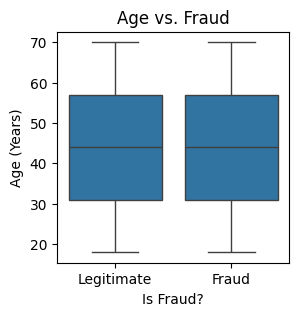

In [19]:
# plot boxplot of age vs. is_fraud
## set figure size
fig, ax = plt.subplots(figsize=(3, 3))

## plot boxplot
sns.boxplot(fraudsynth_train, x='is_fraud', y='age')

## add labels
ax.set(title='Age vs. Fraud', xlabel='Is Fraud?', ylabel='Age (Years)')

## set tick labels
ax.set_xticks(ticks=[0, 1], labels=['Legitimate', 'Fraud'])

## display plot
plt.show()

The boxplot above demonstrates that the minimum, maximum, first quartile, third quartile, and median are identical when viewing the distribution of user ages by fraud status.

Similar visualizations were created for the other variables, which supports the hypothesis that the data was overly synthesized.

Lastly, I view the boxplot of transaction amounts compared based on whether the transactions were fraudulent or not.

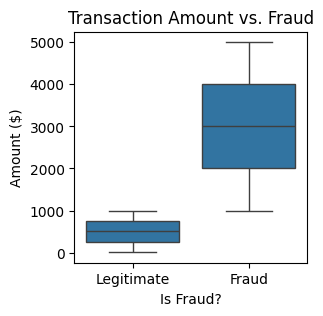

In [20]:
# plot boxplot of amount vs. is_fraud
## set figure size
fig, ax = plt.subplots(figsize=(3, 3))

## plot boxplot
sns.boxplot(fraudsynth_train, x='is_fraud', y='amount')

## add labels
ax.set(title='Transaction Amount vs. Fraud', xlabel='Is Fraud?', ylabel='Amount ($)')

## set tick labels
ax.set_xticks(ticks=[0, 1], labels=['Legitimate', 'Fraud'])

## display plot
plt.show()

__Observation__:

This boxplot demonstrates a distinctly different range of transaction amounts for each class ('fraud' vs. 'legitimate'). The fraudulent transactions were all for higher amounts than the legitimate transactions. This indicates that a machine learning model likely can predict fraudulent activity based on the amount of a transaction.

__Cautionary Note__:

Given the other suspiciously evenly synthesized data, it is worth noting that this boxplot demonstrates an unusually prominent threshold over which transactions are fraudulent: \\$1,000. This is indicated by the top whisker of the legitimate boxplot extending up to \\$1,000 while the bottom whisker of the fraud boxplot extends down to \\$1,000.

In the real-world, I would expect some overlap; stated differently, it is realistic to expect that some transactions above \\$1,000 are legitimate while some transactions below \\$1,000 are fraudulent.

Based on all of the exploratory data analysis, it is clear that this dataset lacks the complexity and richness of real-world data. The oversynthesized nature of the data means that a model trained on this data will likely have very limited predictive value on real-world data that it hasn't seen before.

Regardless, for educational purposes, I will proceed with preparing the data and training a logistic regression model to detect fraud. 

## Data Quality Assessment <a class='anchor' id='quality'></a>

[Click Here to Return to Top](#top)

During my exploratory data analysis (EDA), I uncovered several data quality issues with the FraudSynth dataset. These issues limit the reliability of the model and provide important lessons about working with synthetic data:

1. Perfectly Balanced Dataset

    The dataset has an exact 50/50 split between fraudulent and legitimate transactions. While balanced datasets are often desirable, such a clean split is unrealistic in most real-world fraud detection scenarios, where fraud is relatively rare. This makes it easier for models to predict fraud but reduces their real-world applicability.

2. Zero Correlation Between Features

    When plotting a correlation matrix of the quantitative features, I found no correlation between any of the variables. This suggests that the dataset was synthesized too perfectly, and no meaningful relationships exist between other features. In real-world data, I would expect to see some correlation between features, such as age and income.

3. Categorical Features Show Uniform Distributions

    Similarly, cross-tabulations of the qualitative features revealed a uniform distribution between fraud and legitimate cases, suggesting the features were not simulated to reflect real-world distributions. This overly simplified approach likely prevents the model from learning any complex patterns.

### Why Relying on a Single Feature is Problematic

While performing exploratory data analysis, I found that transaction amount was the only feature that indicates predictive value in determining whether a transaction is fraudulent. However, relying on a single feature is problematic for several reasons:

1. Overfitting to a Single Pattern

   By focusing only on transaction amount, the model fails to generalize well to new data. Real-world fraud detection involves multiple nuanced factors, such as user behavior patterns, location, and timing. If the model is only capturing the relationship between transaction amount and fraud, it might miss other important signals.

2. Lack of Robustness

   In the real world, fraudulent transactions do not always follow a simple, predictable pattern like "large transaction amounts indicate fraud". A model that only learns from one feature may perform poorly if fraudsters change tactics or if new types of fraud emerge.

3. Synthetic Dataset Limitations

   Because the dataset was overly synthesized, the other features— such as age, income, or location— provided no additional predictive value. In real-world scenarios, these features would likely have some influence on fraud detection.

## Prepare the Data <a class='anchor' id='prepare'></a>

[Click Here to Return to Top](#top)

### Feature Selection

Only one of the features ('amount') demonstrated a clear pattern when compared to the target attribute 'is_fraud'. While real-world data likely does have some complex relationships that a machine learning model could detect better than a human performing exploratory data analysis, the exploration indicated that this data was too evenly synthesized. As a result, I will not engage in further feature selection methods.

Below, I create a function that will reduce the raw data to only include the selected feature, 'amount'. This will save time in the future, allowing me to reduce the test data without re-writing the code.

In [21]:
# create function to reduce data to the selected feature
def feature_selection(df):
    X_selection = pd.DataFrame(df['amount'])
    return X_selection

In [22]:
# utilize feature selection function on training data
X_train_selected = feature_selection(X_train)

### Explanation: Lack of Other Data Preprocessing Steps

While this is unusual, there are no further data preprocessing steps. I do not need to encode any variables, given that the only predictive feature is already numeric. Similarly, I do not need to do any scaling, because I do not need to worry about a model focusing on other features with with a different range of values. Lastly, I do not need to impute any values, because the dataset did not have any missing values. While I might consider including imputation in a data pipeline in a different context where new data might be fed to the model with missing values, this model is only being prepared for educational purposes.

## Model Training <a class='anchor' id='train'></a>

[Click Here to Return to Top](#top)

Given the simplicity of the relationship indicated by the training data (i.e. amount > $1,000 is fraud), I will only train one type of machine learning model: a logistic regression classifier.

In [23]:
# instantiate logistic regression class
log_clf = LogisticRegression(random_state=42, max_iter=1000)

### Model Fitting

With the model created, I train it on the data by fitting it to the training data.

In [24]:
# fit logistic regression model to training data
log_clf.fit(X_train_selected, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Model Evaluation: Training Data

I am most interested in correctly predicting whether a transaction is fraudulent, so I can describe potential outcomes as follows:
1. True Positive: A fraudulent transaction that is correctly predicted to be fraudulent
2. True Negative: A legitimate transaction that is correctly predicted to be legitimate
3. False Positive: A legitimate transactions that is incorrectly predicted to be fraudulent
4. False Negative: A fraudulent transactions that is incorrectly predicted to be legitimate

I will evaluate the model based on its accuracy, precision, recall, and F1 score:
1. Accuracy evaluates how accurate the model is; how often did the model correctly predict whether a transaction was fraudulent or legitimate?
2. Precision evaluates how accurate the positive predictions are; for the transactions that the model predicted to be fraudulent, how often were they actually fraudulent?
3. Recall evaluates how well the model recognizes true positive predictions; for the transactions that were fraudulent, how often did the model predict that they were fraudulent?
4. F1 scores are the harmonic mean of precision and recall. The harmonic mean gives more weight to smaller values than the more commonly known arithmetic mean. This metric will only be high if both precision and recall are high.

In this case, I will evaluate all of the above metrics, but I focus on precision more than the recall or the F1 score. Precision emphasizes minimizing false positives. While not all fraud detection scenarios will share this perspective, the data predominantly consists of relatively small dollar amounts for transactions. As a result, I do not want to block small legitimate transactions and bother the customers to determine their legitimacy. If the data I was anticipating had the propensity to involve a higher volume of large value transactions, I might prioritize recall instead, which places an emphasis on identifying true positive predictions and increases the propensity for false positives.

As long as the model has a high degree of overall accuracy, I can accept a few false negatives (allowing a few fraudulent transactions to go undetected) to avoid bothering the clients with investigations into legitimate transactions.

First, I will review these metrics for the training data, to confirm whether the model is demonstrating high metrics on the data it was trained on:

In [25]:
# generate list of predictions
y_train_preds = cross_val_predict(log_clf, X_train_selected, y_train, cv=3)

In [26]:
# compute accuracy score for logistic regression model
accuracy_score(y_train, y_train_preds)

0.9999625

In [27]:
# compute precision score
precision_score(y_train, y_train_preds, pos_label=1)

1.0

In [28]:
# compute recall score
recall_score(y_train, y_train_preds, pos_label=1)

0.999925

In [29]:
# compute F1 score
f1_score(y_train, y_train_preds, pos_label=1)

0.9999624985936972

All of the metrics demonstrate nearly perfect performance on the training data. If I was pursuing this model as a plausible candidate for deployment, I would likely build some additional models so that I could compare performance to either select one model or create an ensemble model using some or all of them. Then, I would likely tune the hyperparameters to optimize model performance.

Given that this is an educational endeavor and I already know that the data is not likely to provide predictive insights that could generalize well to new real-world scenarios, I will proceed directly to testing the model using the test data.

### Model Evaluation: Test Data

Below, I use the feature selection function on the test data before using the model to make predictions. Lastly, I compute the key metrics on these test data predictions to evaluate how the model performs on new data.

In [30]:
# utilize feature selection function on training data
X_test_selected = feature_selection(X_test)

In [31]:
# generate list of predictions
y_test_preds = cross_val_predict(log_clf, X_test_selected, y_test, cv=3)

In [32]:
# compute accuracy score for logistic regression model
accuracy_score(y_test, y_test_preds)

0.9999775

In [33]:
# compute precision score
precision_score(y_test, y_test_preds, pos_label=1)

1.0

In [34]:
# compute recall score
recall_score(y_test, y_test_preds, pos_label=1)

0.999955

In [35]:
# compute F1 score
f1_score(y_test, y_test_preds, pos_label=1)

0.9999774994937386

When evaluating the performance of the final model using the test data:
1. The model performs with the same near-perfect performance that was demonstrated on the training data.
2. In combination with the previous concerns about this synthetic dataset, this level of performance is indicative of extreme overfitting and reinforces the concern that feeding the model real-world data would likely result in an unacceptable amount of false predictions.

## Conclusion <a class='anchor' id='conclusion'></a>

[Click Here to Return to Top](#top)

Given the insights gathered during exploratory data analysis and the subsequent model testing indicating a likelihood of overfitting, I would not recommend deploying this logistic regression classifier. 

Based on the data I saw, it appears that this model is operating at a level of complexity that is no more advanced that traditional non-machine-learning-based fraud detection systems that operate based on fixed rules such as an amount-based threshold. Based on the boxplot of the transaction amounts against the target attribute, I can infer that the model is the equivalent of setting a \\$1,000 threshold for transactions where any transaction above \\$1,000 is investigated to determine whether it is fraudulent.

Even though this project didn't produce a viable model, it was still a valuable exercise in utilizing exploratory data analsis to identify problems with data quality. Additionally, it demonstrating some of the limitations of creating a machine learning model using overly synthesized data that isn't representative of data found in the real-world. 

This isn't the outcome I expected when I first set out to create a fraud detection model, but it is an excellent cautionary tale about the risks of utilizing non-representative data and the importance of working with more realistic, noisy datasets. Ultimately, this was a good stepping stone towards deeper fraud analytics and anomaly detection work that considers real-world data complexities.

## References <a class='anchor' id='references'></a>

[Click Here to Return to Top](#top)

Géron, Aurélien. (2023). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, Third Edition*. O'Reilly Media.

Ismail, Youssef. (2024, February 29). *FraudSynth: Credit Fraud Detection Dataset*. Kaggle. https://www.kaggle.com/datasets/youssefismail20/fraudsynth-credit-fraud-detection-dataset